# STM Transit Delay Feature Engineering and Data Preprocessing

This notebook preprocesses data about STM trip updates and weather data in order to build a tree-based regression model that predicts delays in seconds.

## Data Description

`trip_id` unique identifier of a trip<br>
`vehicle_id` unique identifier of a vehicle<br>
`occupancy_status` degree of passenger occupancy<br>
`route_id` bus or metro line<br>
`stop_id` stop number<br>
`stop_lat`stop latitude<br>
`stop_lon`stop longitude<br>
`stop_sequence` sequence of the stop, for ordering<br>
`trip_progress` how far along the trip is the bys from 0 to 1<br>
`wheelchair_boarding` indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false<br>
`realtime_arrival_time` actual arrival time, in milliseconds<br>
`scheduled_arrival_time` planned arrival time, in milliseconds<br>
`temperature` air temperature at 2 meters above ground, in Celsius<br>
`precipitation` total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters<br>
`windspeed` wind speed at 10 meters above ground, in km/h<br>
`weathercode` World Meteorological Organization (WMO) code<br>
`incident_nearby`indicates if an incident happened within 500 meters when the vehicle arrived at the stop

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import INCIDENT_CATEGORIES, LOCAL_TIMEZONE, WEATHER_CODES

In [3]:
# Load data
df = pd.read_csv('../data/stm_weather_traffic_merged.csv')

## Feature Engineering

In [4]:
# Convert real and scheduled timestamps
df['realtime_arrival_time'] = pd.to_datetime(df['realtime_arrival_time'], origin='unix', unit='ms', utc=True)
df['scheduled_arrival_time'] = pd.to_datetime(df['scheduled_arrival_time'], origin='unix', unit='ms', utc=True)

In [5]:
# Calculate delay in seconds (real - scheduled)
df['delay'] = (df['realtime_arrival_time'] - df['scheduled_arrival_time']).dt.total_seconds()

## Small EDA

In [6]:
# Get correlations of features with delay
correlations = df.corr().iloc[:-1]['delay']
correlations.sort_values(key=abs, ascending=False)

stop_sequence                0.095438
trip_progress                0.070046
occupancy_status             0.049286
incident_delay              -0.034499
incident_category            0.032713
incident_delay_magnitude    -0.032362
temperature                 -0.028813
windspeed                   -0.028704
nearest_incident_distance   -0.026618
stop_lat                     0.023818
trip_id                     -0.023159
route_id                     0.021167
realtime_arrival_time        0.021010
stop_lon                     0.013707
scheduled_arrival_time       0.010111
incident_nearby             -0.009394
vehicle_id                   0.006746
weathercode                  0.006687
stop_id                      0.001885
wheelchair_boarding          0.001230
Name: delay, dtype: float64

In [7]:
# Get distribution of delays
df['delay'].describe()

count    34666.000000
mean        57.620233
std        258.499290
min      -8222.000000
25%          0.000000
50%          0.000000
75%         69.000000
max      19116.000000
Name: delay, dtype: float64

In [8]:
# Get proportion of trips that are on time
on_time_mask = df['delay'] == 0
print(f'{(on_time_mask.sum() / len(df)):.2%}')

63.45%


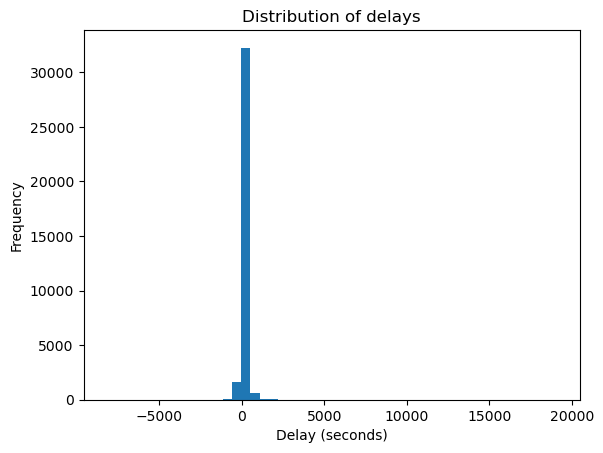

In [9]:
# Plot distribution of delays
plt.hist(df['delay'], bins=50)
plt.title('Distribution of delays')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_hist.png', bbox_inches='tight')
plt.show()

The plot shows there are some massive delays (~2h15min early to ~5h15min late), which could greatly affect the model performance.

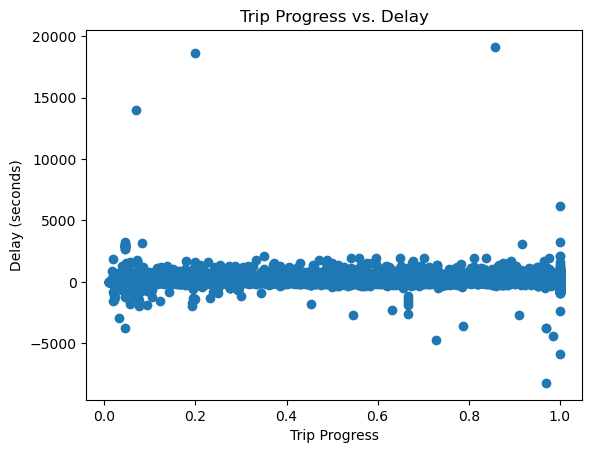

In [10]:
# Plot trip progress vs. delay
plt.scatter(x=df['trip_progress'], y=df['delay'])
plt.title('Trip Progress vs. Delay')
plt.xlabel('Trip Progress')
plt.ylabel('Delay (seconds)')
plt.savefig('../images/trip_progress_vs_delay.png', bbox_inches='tight')
plt.show()

From the plot, it looks like the delay is relatively stable across the trip progress. There are many data points that appear scattered around the x-axis, indicating that delays do not change significantly throughout the trip in many cases. The wide range of delays suggests that delays are highly variable, but there is not clear relationship between trip progress and delay. This could imply that other factors like traffic, accidents, mechanical issues or weather may have more impact on the delays.

## Data Preprocessing

### Handle Outliers

In [11]:
# Compute mean and standard deviation
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

In [12]:
# Filter outliers based on standard deviation
outlier_mask = (df['delay'] < mean_delay - 3 * std_delay) | (df['delay'] > mean_delay + 3 * std_delay)

In [13]:
# Get outliers
outliers = df[outlier_mask]

In [14]:
# Get proportion of outliers
print(f'{(outlier_mask.sum() / len(df)):.2%}')

1.00%


In [15]:
# Remove outliers
df = df[~outlier_mask]

In [16]:
# Get new distribution
df['delay'].describe()

count    34321.000000
mean        50.247720
std        127.415368
min       -705.000000
25%          0.000000
50%          0.000000
75%         64.000000
max        833.000000
Name: delay, dtype: float64

The delay ranging from ~16 min early to 18min45sec seems more reasonable.

In [17]:
df.columns

Index(['trip_id', 'vehicle_id', 'occupancy_status', 'route_id', 'stop_id',
       'stop_lat', 'stop_lon', 'stop_sequence', 'trip_progress',
       'wheelchair_boarding', 'realtime_arrival_time',
       'scheduled_arrival_time', 'temperature', 'windspeed', 'weathercode',
       'incident_nearby', 'incident_category', 'nearest_incident_distance',
       'incident_delay', 'incident_delay_magnitude', 'delay'],
      dtype='object')

### Encode Datetime

In [18]:
# Convert arrival times to local timezone
df['realtime_arrival_time'] = df['realtime_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)
df['scheduled_arrival_time'] = df['scheduled_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)

In [19]:
# Convert datetimes to day and hour
df['day'] = df['realtime_arrival_time'].dt.day_of_week
df['hour'] = df['realtime_arrival_time'].dt.hour

df['sch_day'] = df['scheduled_arrival_time'].dt.day_of_week
df['sch_hour'] = df['scheduled_arrival_time'].dt.hour

In [20]:
# Use Cyclical Encoding for day and hour, as it's more suitable for time-related features
# And the model can "understand" the wrap-around
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)

df['sch_day_sin'] = np.sin(2 * np.pi * df['sch_day'] / 7)
df['sch_day_cos'] = np.cos(2 * np.pi * df['sch_day'] / 7)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['sch_hour_sin'] = np.sin(2 * np.pi * df['sch_hour'] / 24)
df['sch_hour_cos'] = np.cos(2 * np.pi * df['sch_hour'] / 24)

In [21]:
# Add boolean value is_weekend
weekend_mask = df['day'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [22]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

### Use Label Encoding for vehicle_id, route_id and stop_id

In [23]:
le_vehicle = LabelEncoder()
df['vehicle_id'] = le_vehicle.fit_transform(df['vehicle_id'])

In [24]:
le_route = LabelEncoder()
df['route_id'] = le_route.fit_transform(df['route_id'])

In [25]:
le_stop = LabelEncoder()
df['stop_id'] = le_stop.fit_transform(df['stop_id'])

### Convert weathercode to Categories

In [26]:
# Create weather code mapping
weathercodes = df['weathercode'].sort_values().unique()
condition_list = []
label_list = []

for code in weathercodes:
  condition_list.append(df['weathercode'] == code)
  label_list.append(WEATHER_CODES[code])

In [27]:
# Create categories
df['weather'] = np.select(condition_list, label_list, default='Unknown')

In [28]:
df['weather'].value_counts()

weather
Clear sky    29170
Overcast      5151
Name: count, dtype: int64

In [29]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['weather'], drop_first=True, dtype='int64', prefix='weather')
df = df.join(one_hot)

### Convert incident_category to Categories 

In [30]:
# Create incident code mapping
df['incident_category'] = df['incident_category'].fillna(99)

incident_codes = df['incident_category'].sort_values().unique()
condition_list = []
label_list = []

for code in incident_codes:
  condition_list.append(df['incident_category'] == code)
  label_list.append(INCIDENT_CATEGORIES[code])

In [31]:
# Create categories
df['incident'] = np.select(condition_list, label_list)

In [32]:
df['incident'].value_counts()

incident
Jam           1787
RoadClosed     167
RoadWorks       53
Name: count, dtype: int64

In [34]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['incident'], drop_first=True, dtype='int64', prefix='incident')
df = df.join(one_hot)

## Export Data

In [37]:
df.columns

Index(['trip_id', 'vehicle_id', 'occupancy_status', 'route_id', 'stop_id',
       'stop_lat', 'stop_lon', 'stop_sequence', 'trip_progress',
       'wheelchair_boarding', 'realtime_arrival_time',
       'scheduled_arrival_time', 'temperature', 'windspeed', 'weathercode',
       'incident_nearby', 'incident_category', 'nearest_incident_distance',
       'incident_delay', 'incident_delay_magnitude', 'delay', 'day', 'hour',
       'sch_day', 'sch_hour', 'day_sin', 'day_cos', 'sch_day_sin',
       'sch_day_cos', 'hour_sin', 'hour_cos', 'sch_hour_sin', 'sch_hour_cos',
       'is_weekend', 'is_peak_hour', 'weather', 'weather_Overcast', 'incident',
       'incident_RoadClosed', 'incident_RoadWorks'],
      dtype='object')

In [38]:
# Keep encoded columns and reorder them
df = df[[
	'vehicle_id',
  	'occupancy_status',
  	'route_id', 
  	'stop_id',
  	'stop_lat',
  	'stop_lon',
	'stop_sequence',
  	'trip_progress',
	'wheelchair_boarding',
  	'day_sin',
  	'day_cos',
  	'sch_day_sin',
  	'sch_day_cos',
  	'hour_sin',
  	'hour_cos', 
	'sch_hour_sin',
  	'sch_hour_cos',
  	'is_weekend',
  	'is_peak_hour', 
	'temperature', 
	#'precipitation', 
	'windspeed', 
  	#'weather_Drizzle',
	#'weather_Mainly clear', 
  	'weather_Overcast',
  	#'weather_Partly cloudy',
    #'weather_Slight rain',
    'incident_nearby',
    'nearest_incident_distance',
  	'incident_delay',
	'incident_delay_magnitude',
	'incident_RoadClosed',
  	'incident_RoadWorks',
  	'delay'
]]

In [39]:
# Export encoders
encoders = {
	'le_vehicle': le_vehicle,
  	'le_route': le_route,
  	'le_stop': le_stop,
}

with open('../models/label_encoders.pickle', 'wb') as handle:
	pickle.dump(encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34321 entries, 0 to 34665
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   vehicle_id                 34321 non-null  int64  
 1   occupancy_status           34321 non-null  int64  
 2   route_id                   34321 non-null  int64  
 3   stop_id                    34321 non-null  int64  
 4   stop_lat                   34321 non-null  float64
 5   stop_lon                   34321 non-null  float64
 6   stop_sequence              34321 non-null  int64  
 7   trip_progress              34321 non-null  float64
 8   wheelchair_boarding        34321 non-null  int64  
 9   day_sin                    34321 non-null  float64
 10  day_cos                    34321 non-null  float64
 11  sch_day_sin                34321 non-null  float64
 12  sch_day_cos                34321 non-null  float64
 13  hour_sin                   34321 non-null  float64


In [41]:
# Export dataframe
df.to_csv('../data/preprocessed.csv', index=False)

## End